Тут я сложил в data/microcap/номер файлы для резистеров разных номиналов. И измеряю отклонение разными методами по этому файлу

In [122]:
%load_ext autoreload 
%autoreload 2

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(os.path.join(os.getcwd(), ".."))

import math
import numpy as np
import pandas as pd
from numpy import array
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from math import sin, pi
from scipy import signal
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import importlib
import model as md
import view as vw

importlib.reload(md)
importlib.reload(vw)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users\Артем\Desktop\Вуз\Аспирантура\Диссертация\Алгоритм\Relaxation_frequency_phase_algorithm\notebooks\Complex_ms\..


<module 'view' from 'c:\\Users\\Артем\\Desktop\\Вуз\\Аспирантура\\Диссертация\\Алгоритм\\Relaxation_frequency_phase_algorithm\\view\\__init__.py'>

In [123]:
dir = os.path.join(project_root, "data","microcap")

folder_names = [
    name for name in os.listdir(dir)
    if os.path.isdir(os.path.join(dir, name))
]

folder_paths = [os.path.join(dir, name) for name in folder_names]

In [124]:
U_mass=[]
I_mass=[]
t_mass=[]

for i in range(0,len(folder_paths),1):
    
    U_path = os.path.join(folder_paths[i], "U.CSV")
    I_path= os.path.join(folder_paths[i], "I.CSV")

    t,U = md.make_microcap_data_list(U_path)
    t,I = md.make_microcap_data_list(I_path)

    U_mass.append(U)
    I_mass.append(I)
    t_mass.append(t)
    

In [125]:
phase_real=md.get_phase_RC_real(444e3,128.35,869.31e-12)
phase_real_graph= np.full(len(folder_names), phase_real)

In [126]:
phase_methods = [
    md.get_phase_maxpoint,
    md.get_phase_hilbert,
    md.get_phase_FFT,
    md.get_phase_lockin,
    md.get_phase_xcorr2
]

In [127]:
phase_errors_all_methos=[]

for method in (phase_methods):
    phase_errors=[]
    for i in range (0,len(U_mass),1):
        F,V = md.get_spectrum3(t_mass[i],U_mass[i])
        F_peak_calc = F[np.argmax(V)]
        time_maxpoint,  phase_maxpoint  = method(t_mass[i], U_mass[i], I_mass[i], F_peak_calc, 20)
        kde=md.get_kde_mode(phase_maxpoint)
        phase_error = abs(abs(kde) - abs(phase_real))
        phase_errors.append(phase_error)
    phase_errors_all_methos.append(phase_errors)

In [129]:
def clean_name(func):
    return func.__name__.replace("get_phase_", "").replace("get_phase", "")

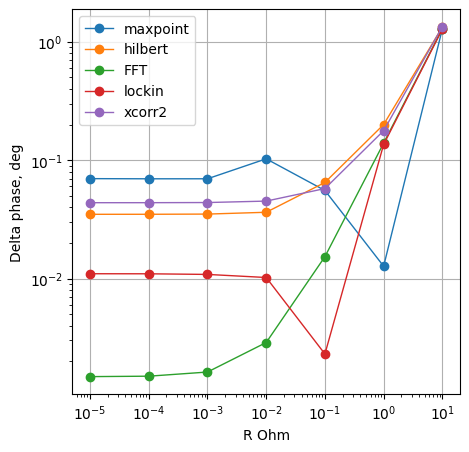

In [130]:
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot()
front=10

int_numbers = [float(s) for s in folder_names]
for i in range(0,len(phase_methods),1):
    ax1.plot(int_numbers, phase_errors_all_methos[i]  , 'o-', label=clean_name(phase_methods[i]), linewidth=1)


ax1.set_xlabel('R Ohm', fontsize=front)
ax1.set_ylabel('Delta phase, deg', fontsize=front)
ax1.legend(fontsize=front)
ax1.grid(True)
ax1.set_yscale("log")
ax1.set_xscale("log")

In [138]:
# выбираем первую точку, где изменение > порога (например, 10% threshold =0.1)
threshold = 0.001

for i in range(0,len(phase_methods),1):
    y=phase_errors_all_methos[i]
    x=int_numbers
    dy = np.abs(np.diff(y) / y[:-1])
    idx = np.where(dy > threshold)[0][0] + 1
    print(clean_name(phase_methods[i]))
    print(f"Выход с плато примерно на x = {x[idx]}, y = {y[idx]}")

maxpoint
Выход с плато примерно на x = 0.0001, y = 0.06960911770655898
hilbert
Выход с плато примерно на x = 0.001, y = 0.035045852493482244
FFT
Выход с плато примерно на x = 0.0001, y = 0.0014976116190794642
lockin
Выход с плато примерно на x = 0.0001, y = 0.010971079605226919
xcorr2
Выход с плато примерно на x = 0.001, y = 0.04387057210504608
